In [1]:
!pip install numpy opencv-python pillow albumentations tensorflow kagglehub

In [2]:
# !pip install keras

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import numpy as np

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torchvision.models as models

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

tf.config.optimizer.set_jit(True)

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
import kagglehub

# Free download
path = kagglehub.dataset_download("alessandrasala79/ai-vs-human-generated-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-vs-human-generated-dataset


In [7]:
# Set to a number to specify size of training data; should be an even number
# None = max training size
# TRAIN_SIZE = 10000
TRAIN_SIZE = None

In [8]:
!nvidia-smi

Tue Apr 22 06:18:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [10]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available, using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available, using CPU. Too bad!!")

CUDA is available, using GPU.


In [11]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set fixed seed
set_seed(42)

In [12]:
# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content"
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! chmod 600 /content/kaggle.json
# ! kaggle datasets list

In [13]:
import tensorflow as tf

# List GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Optional: log device placement to see ops on /GPU:0
tf.debugging.set_log_device_placement(True)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
# Load the dataset
base_dir = path
df_path = "/content"
# train_df = pd.read_csv(path + "/train.csv")
test_df = pd.read_csv(path + "/test.csv")
train_df = pd.read_csv(os.path.join(df_path, "train_20000.csv"))
# test_df = pd.read_csv(os.path.join(df_path, "test_1000.csv"))

# Display basic info
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", test_df.shape)

# Reduce size of train dataset for easier processing
if TRAIN_SIZE is not None and TRAIN_SIZE < train_df.shape[0]:
  train_df = train_df.loc[0:(TRAIN_SIZE - 1)]
  print("Train dataset shape after reduction:", train_df.shape)
train_df.head()
train_df.shape

Train dataset shape: (20000, 3)
Test dataset shape: (5540, 1)


(20000, 3)

In [15]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df.head()

,file_name,label
0,a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,041be3153810433ab146bc97d5af505c.jpg,0
2,615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,8542fe161d9147be8e835e50c0de39cd.jpg,0
4,5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1


In [16]:
# Add base directory to all file_name fields to make it easier to read each image
test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir, x))
# train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir, x))
# test_df['id'] = test_df['id'].apply(lambda x: os.path.join(base_dir + "/test_data_v2", x))
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(base_dir + "/train_data", x))

In [17]:
print(train_df['file_name'].iloc[0])

/kaggle/input/ai-vs-human-generated-dataset/train_data/a6dcb93f596a43249135678dfcfc17ea.jpg


In [18]:
print(test_df['id'].iloc[0])

/kaggle/input/ai-vs-human-generated-dataset/test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg


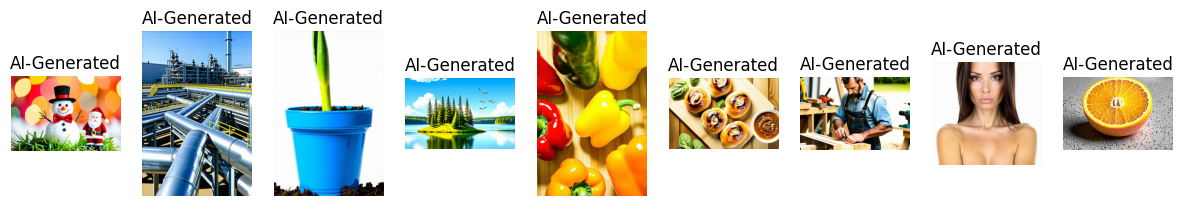

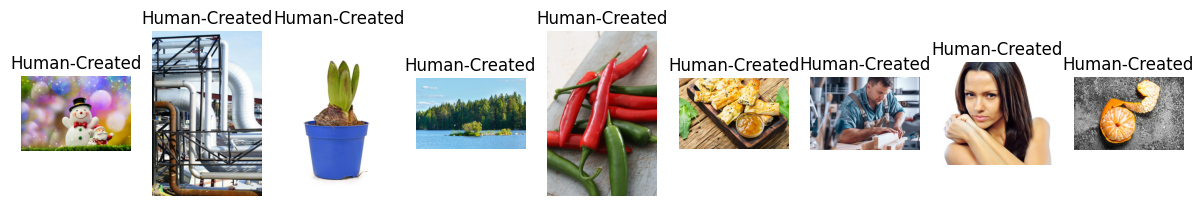

In [19]:
# Function to display images
def show_images(df, label, num_images=9):
    sample_images = df[df["label"] == label].sample(num_images, random_state=15)["file_name"].values

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Read image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("AI-Generated" if label == 1 else "Human-Created")

    plt.show()

# Show AI-Generated Images
show_images(train_df, label=1)

# Show Human-Created Images
show_images(train_df, label=0)

In [20]:
def load_and_resize(path, IMG_SIZE=(128, 128)):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models

class ResidualTracker(tf.keras.callbacks.Callback):
    def __init__(self, X_val):
        self.X_val = X_val
        self.variances = []

    def on_epoch_end(self, epoch, logs=None):
        recon = self.model.predict(self.X_val)
        residuals = np.mean((self.X_val - recon) ** 2, axis=(1, 2, 3))
        variance = np.var(residuals)
        self.variances.append(variance)
        print(f"Epoch {epoch + 1} - Residual Variance: {variance:.5f}")


# Build AE
def build_autoencoder(input_shape):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D(2)(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(encoded)
    x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)
    out = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    return models.Model(inp, out)



In [ ]:
# Prepare only human images for AE training
X_ae = np.stack([load_and_resize(path) for path in train_df[train_df["label"] == 0]["file_name"].values])

ae = build_autoencoder((128, 128, 3))
ae.compile(optimizer="adam", loss="mse")

ds_ae = (
    tf.data.Dataset
      .from_tensor_slices((X_ae, X_ae))
      .shuffle(buffer_size=len(X_ae))
      .batch(32)
      .prefetch(AUTOTUNE)
)


ae.fit(ds_ae,
       epochs=100,
       validation_data=ds_ae.take(int(0.1 * len(X_ae)//32)))

ae.trainable = False

In [ ]:
ae.save_weights('autoencoder_weights.weights.h5')

In [28]:
ae = build_autoencoder((128, 128, 3))
ae.load_weights('autoencoder_weights.weights.h5')

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:loc

In [ ]:
def extract_fft_mag(img):
    fft = np.fft.fft2(img, axes=(0, 1))
    fft_shifted = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shifted)
    norm_mag = magnitude / np.max(magnitude)
    return norm_mag

# train_df["frequency"] = train_df["image"].apply(extract_fft_mag)
# test_df["frequency"] = test_df["image"].apply(extract_fft_mag)

In [22]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 64

@tf.function
def parse_and_combine(path, label):
    # read + decode + resize + normalize
    img = load_and_resize(path, IMG_SIZE)

    # 2) residual via the AE (in graph, no .predict() call)
    recon = ae(img[None, ...], training=False)[0]
    recon = tf.cast(recon, tf.float32)
    residual = tf.abs(img - recon)

    # 3) FFT magnitude map via tf.signal
    gray = tf.image.rgb_to_grayscale(img)
    fft = tf.signal.fft2d(tf.cast(gray[...,0], tf.complex64))
    fft = tf.signal.fftshift(fft)
    mag = tf.abs(fft)
    mag /= tf.reduce_max(mag) + 1e-8
    fft_map = tf.tile(mag[...,None], [1,1,3])

    # 4) concat → 6 channels
    combined = tf.concat([residual, fft_map], axis=-1)

    # 5) one‑hot encode
    label = tf.one_hot(label, depth=2)

    return combined, label

In [29]:
train_paths = train_df['file_name'].values
train_labels = train_df['label'].values


def decode_and_normalize(path, label):
    img = load_and_resize(path, IMG_SIZE)       # tf.io + tf.image ops, CPU‐bound but multithreaded
    label = tf.one_hot(label, depth=2)
    return img, label

raw_ds = (tf.data.Dataset
            .from_tensor_slices((train_paths, train_labels))
            .shuffle(len(train_paths))
            .map(decode_and_normalize, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .cache()                                 # optional, if your data fits in RAM
         )

@tf.function
def batch_parse_and_combine(img_batch, label_batch):
    # [B, H, W, 3]
    # AE produces a batch of reconstructions
    recon_batch = ae(img_batch, training=False)   # [B, H, W, 3] on GPU
    recon_batch = tf.cast(recon_batch, tf.float32)
    residual = tf.abs(img_batch - recon_batch)

    # FFT: vectorized over the batch
    gray = tf.image.rgb_to_grayscale(img_batch)   # [B, H, W, 1]
    # tf.signal.fft2d only works on the last two dims; so reshape:
    x = tf.cast(gray[..., 0], tf.complex64)       # [B, H, W]
    fft = tf.signal.fftshift(tf.signal.fft2d(x))  # [B, H, W]
    mag = tf.abs(fft)
    mag = mag / (tf.reduce_max(mag, axis=[1,2], keepdims=True) + 1e-8)  # normalize per example
    fft_map = tf.tile(mag[...,None], [1,1,1,3])   # [B, H, W, 3]

    combined = tf.concat([residual, fft_map], axis=-1)  # [B, H, W, 6]
    return combined, label_batch

# ds = ( raw_ds
#                .map(batch_parse_and_combine, num_parallel_calls=AUTOTUNE)
#                .apply(tf.data.experimental.prefetch_to_device('/GPU:0'))  # move batches onto GPU asap
#                .prefetch(AUTOTUNE) )

ds = (
  tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(len(train_paths))
    .map(decode_and_normalize, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(batch_parse_and_combine, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
    .apply(tf.data.experimental.prefetch_to_device('/GPU:0'))
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorSliceDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op BatchDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op DummyMemoryCache in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op CacheDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
E

In [33]:
val_size = int(0.1 * len(train_paths))
train_ds = ds.skip(val_size).apply(tf.data.experimental.prefetch_to_device('/GPU:0'))
val_ds   = ds.take(val_size).apply(tf.data.experimental.prefetch_to_device('/GPU:0'))
val_labels = train_df["label"].values[-val_size:]

Executing op SkipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op WrapDatasetVariant in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TakeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op WrapDatasetVariant in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op GeneratorDataset in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:GPU:0


In [30]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tensorflow.keras.utils import to_categorical

# def prepare_dual_inputs(df):
#     residuals = np.stack(df["residual"].values)
#     frequencies = np.stack(df["frequency"].values)
#     return np.concatenate([residuals, frequencies], axis=-1)

# X_train = prepare_dual_inputs(train_df)
# y_train = to_categorical(train_df["label"].values)
# X_test = prepare_dual_inputs(test_df)
# y_test = to_categorical(test_df["label"].values)

# DRAFFNet
def build_dualstream_cnn(input_shape):
    model = models.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(2, activation='softmax')
    ])
    return model

train_steps_per_epoch = len(train_paths) // BATCH_SIZE  # Batch size
val_steps_per_epoch = val_size // BATCH_SIZE

model = build_dualstream_cnn((128, 128, 6))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

with tf.device('/GPU:0'):
    history = model.fit(train_ds, epochs=1, validation_data=val_ds)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:local

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs   = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(val_labels, axis=1)

print(classification_report(y_true, y_pred_classes))
print("ROC-AUC:", roc_auc_score(y_true, y_pred_classes[:, 1]))

# Confusion matrix
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# Residual visualization (for FP/FN)
false_pred_indices = np.where(y_true != y_pred_classes)[0]
for i in false_pred_indices[:5]:
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(test_df.iloc[i]["image"])
    plt.title("Original")
    plt.subplot(1, 3, 2)
    plt.imshow(test_df.iloc[i]["residual"])
    plt.title("Residual")
    plt.subplot(1, 3, 3)
    plt.imshow(test_df.iloc[i]["frequency"])
    plt.title("FFT")
    plt.show()

# t-SNE on final features
from sklearn.manifold import TSNE

feature_model = models.Model(model.input, model.layers[-2].output)
features = feature_model.predict(X_test)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=y_true, palette=["royalblue", "crimson"])
plt.title("t-SNE of DRAFFNet Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
class ResidualTracker(tf.keras.callbacks.Callback):
    def __init__(self, X_val):
        self.X_val = X_val
        self.variances = []

    def on_epoch_end(self, epoch, logs=None):
        recon = self.model.predict(self.X_val)
        residuals = np.mean((self.X_val - recon) ** 2, axis=(1, 2, 3))
        variance = np.var(residuals)
        self.variances.append(variance)
        print(f"Epoch {epoch + 1} - Residual Variance: {variance:.5f}")

tracker = ResidualTracker(X_ae[:100])
ae.fit(X_ae, X_ae, epochs=10, batch_size=32, validation_split=0.1, callbacks=[tracker])


In [ ]:


# Build your classification model
model = build_dualstream_cnn((128,128,6))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_ds, epochs=100, validation_data=val_ds)

In [ ]:

# === Alias for autoencoder (Option 1 fix) ===
ae  # Assuming your trained autoencoder is stored in variable `ae`

# === FFT function ===
def compute_fft(image):
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    f = np.fft.fft2(gray)
    fshift = np.fft.fftshift(f)
    magnitude = 20 * np.log(np.abs(fshift) + 1e-8)
    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    fft_map = np.stack([magnitude] * 3, axis=-1) / 255.0  # Convert to RGB shape
    return fft_map

# === Image Generator with Residual + FFT ===
class StreamTestImageGenerator(Sequence):
    def __init__(self, image_paths, ae, batch_size=32, img_size=(128, 128)):
        self.image_paths = image_paths
        self.autoencoder = ae
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_paths = self.image_paths[index * self.batch_size : (index + 1) * self.batch_size]
        batch_combined = []
        batch_ids = []

        for path in batch_paths:
            img = cv2.imread(path)
            if img is None:
                raise RuntimeError(f"[❌] Failed to load image: {path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0

            residual = img - self.autoencoder.predict(np.expand_dims(img, 0), verbose=0)[0]
            fft_map = compute_fft(img)

            combined = np.concatenate([residual, fft_map], axis=-1)  # Shape: (128,128,6)
            batch_combined.append(combined)
            batch_ids.append(os.path.basename(path))

        return np.array(batch_combined), batch_ids

# === Load image paths ===
image_paths = sorted([
    os.path.join(TEST_DIR, f)
    for f in os.listdir(TEST_DIR)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

# === Create generator ===
gen = StreamTestImageGenerator(image_paths, autoencoder=ae, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

# === Initialize CSV ===
with open(SAVE_CSV, "w") as f:
    f.write("id,label\n")

# === Prediction Loop ===
print("[🧠] Starting prediction...")
for i in tqdm(range(len(gen)), desc="Batch Prediction"):
    batch_imgs, batch_ids = gen[i]
    preds = model.predict_on_batch(batch_imgs)
    pred_classes = np.argmax(preds, axis=1)

    with open(SAVE_CSV, "a") as f:
        for id_, label in zip(batch_ids, pred_classes):
            f.write(f"{id_},{label}\n")

print(f"[✅] Done. Results saved to {SAVE_CSV}")



In [ ]:
test_paths = test_df['file_name'].values

test_ds = (tf.data.Dataset.from_tensor_slices(test_paths)
  .shuffle(len(train_paths))
  .map(parse_and_preprocess, num_parallel_calls=AUTOTUNE)
  .batch(32)
  .prefetch(AUTOTUNE)
)


test_predictions = np.argmax(model.predict(test_ds), axis=1)

submission_df = test_df.copy()  # Copy original test dataframe

# Extract only the filename from the full path
submission_df["id"] = submission_df["id"].apply(lambda x: x.split("/")[-1])
# Reattach `test_data_v2/` prefix
submission_df["id"] = "test_data_v2/" + submission_df["id"]
# Add predictions
submission_df["label"] = test_predictions  # Assign 1D predictions

submission_df.to_csv("submission.csv", index=False)